# DocAI PDF Clustering Analysis Tool

* Author: docai-incubator@google.com

## Disclaimer

This tool is not supported by the Google engineering team or product team. It is provided and supported on a best-effort basis by the DocAI Incubator Team. No guarantees of performance are implied.

## Objective

The tool is designed to perform advanced image analysis and clustering on PDF documents. It utilizes the VGG16 deep learning model to extract and process image features from PDF pages, applies PCA for dimensionality reduction, and employs K-Means clustering to categorize the images into distinct groups. The tool aims to facilitate efficient organization and analysis of visual data contained in large sets of PDF files.

## Step by step procedure

### Install the required libraries

In [ ]:
!pip install PyPDF2 Pillow numpy scikit-learn matplotlib tensorflow pdf2image pandas

### Import the required libraries

In [ ]:
import os
import PyPDF2
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from pdf2image import convert_from_path
from typing import List
from collections import defaultdict
import pandas as pd

### Setup the required inputs

In [ ]:
# Directory containing PDFs for the cluster analysis
pdf_dir = "/home/jupyter/<your-pdf-path>"

### Run the Code

In [15]:
def convert_pdf_to_images(pdf_path: str) -> List[Image.Image]:
    """
    Convert each page of a PDF file into images.

    Args:
    pdf_path (str): The file path of the PDF.

    Returns:
    List[Image.Image]: A list of PIL Image objects, one for each page of the PDF.
    """
    return convert_from_path(pdf_path)


def extract_images_from_pdf(pdf_path: str) -> List[Image.Image]:
    """
    Extract embedded images from a PDF file.

    Args:
    pdf_path (str): The file path of the PDF.

    Returns:
    List[Image.Image]: A list of extracted PIL Image objects.
    """
    images = []
    with open(pdf_path, "rb") as file:
        pdf = PyPDF2.PdfReader(file)
        for page in pdf.pages:
            if "/XObject" in page["/Resources"]:
                xObject = page["/Resources"]["/XObject"].getObject()
                for obj in xObject:
                    if xObject[obj]["/Subtype"] == "/Image":
                        size = (xObject[obj]["/Width"], xObject[obj]["/Height"])
                        data = xObject[obj]._data
                        if xObject[obj]["/ColorSpace"] == "/DeviceRGB":
                            mode = "RGB"
                        else:
                            mode = "P"
                        image = Image.frombytes(mode, size, data)
                        images.append(image)
    return images


def preprocess_images(images: List[Image.Image]) -> np.ndarray:
    """
    Preprocess a list of images for VGG16 model.

    Args:
    images (List[Image.Image]): A list of PIL Image objects.

    Returns:
    np.ndarray: A numpy array of processed images suitable for VGG16 model input.
    """
    processed_images = []
    for image in images:
        image = image.resize((224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        processed_images.append(image)

    if processed_images:
        return np.vstack(processed_images)
    else:
        return np.array(processed_images)  # Return an empty numpy array if no images


# Load VGG16 model
model = VGG16(include_top=False, weights="imagenet", pooling="avg")

# Process each PDF
features = []
file_mappings = []  # To map features to filenames

for pdf_file in os.listdir(pdf_dir):
    if pdf_file.endswith(".pdf"):
        pdf_path = os.path.join(pdf_dir, pdf_file)
        images = convert_pdf_to_images(pdf_path)  # or extract_images_from_pdf(pdf_path)
        processed_images = preprocess_images(images)

        if processed_images.size > 0:
            pdf_features = model.predict(processed_images)
            features.append(pdf_features)
            file_mappings.extend([(pdf_file, feature) for feature in pdf_features])

# Combine features from all PDFs
features = np.vstack([feature for _, feature in file_mappings])

# Apply PCA
pca = PCA(n_components=0.9)  # Adjust the number of components as needed
pca_features = pca.fit_transform(features)

1/1 [==============================] - 0s 101ms/step


## Execute the following code to utilize the Elbow method for determining the ideal number of clusters

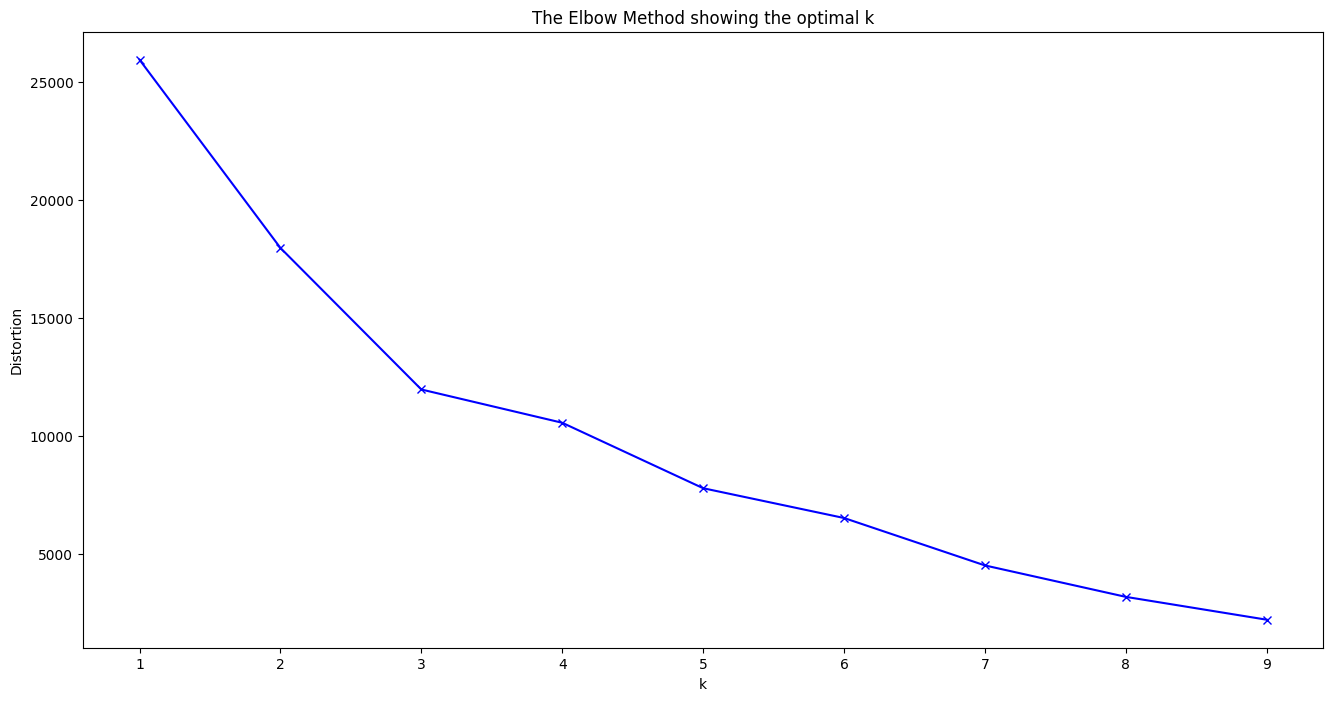

In [16]:
distortions = []
K = range(1, 10)  # Adjust the range as needed
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pca_features)
    distortions.append(kmeanModel.inertia_)

# Plot the Elbow
plt.figure(figsize=(16, 8))
plt.plot(K, distortions, "bx-")
plt.xlabel("k")
plt.ylabel("Distortion")
plt.title("The Elbow Method showing the optimal k")
plt.show()

## Choose the right number of clusters based on the Elbow method

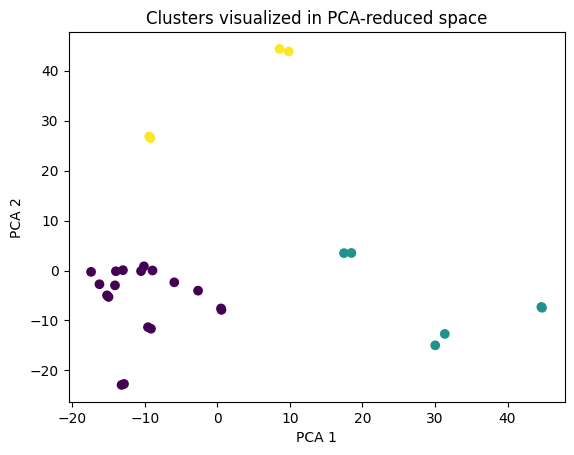

In [17]:
num_clusters = 3  # Replace with the chosen number of clusters
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(pca_features)

# Visualizing the clusters
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap="viridis")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters visualized in PCA-reduced space")
plt.show()

## View the mapping of each filename to its corresponding cluster.

In [18]:
# Create a DataFrame for cluster mapping
cluster_data = []
for cluster, filenames in cluster_mapping.items():
    for filename in set(filenames):  # Use set to avoid duplicate filenames
        cluster_data.append({"Cluster": cluster, "Filename": filename})

df = pd.DataFrame(cluster_data)

# Sort by cluster and then filename for better readability
df.sort_values(by=["Cluster", "Filename"], inplace=True)

# Display the DataFrame as a table
print(df.to_string(index=False))

 Cluster                      Filename
       0 Accessmedia_synthesized_1.pdf
       0 Accessmedia_synthesized_2.pdf
       0     Hotwire_synthesized_1.pdf
       0     Hotwire_synthesized_2.pdf
       0     Lion_Co_synthesized_1.pdf
       0     Lion_Co_synthesized_2.pdf
       1        ACME_synthesized_1.pdf
       1        ACME_synthesized_2.pdf
       1         ADP_synthesized_1.pdf
       1         ADP_synthesized_2.pdf
       1    American_synthesized_1.pdf
       1    American_synthesized_2.pdf
       1        Cele_synthesized_1.pdf
       1        Cele_synthesized_2.pdf
       1       Covey_synthesized_1.pdf
       1       Covey_synthesized_2.pdf
       1      Globex_synthesized_1.pdf
       1      Globex_synthesized_2.pdf
       1       IETEC_synthesized_1.pdf
       1       IETEC_synthesized_2.pdf
       1  Imagintime_synthesized_1.pdf
       1  Imagintime_synthesized_2.pdf
       1       Jacks_synthesized_1.pdf
       1       Jacks_synthesized_2.pdf
       2           Brick_